# Measuring the Supermassive Black Hole at the Galactic Center

**GitHub Repository:** https://github.com/JacobParzych/Astron_1221_Project_3

## Project Overview

This project analyzes the orbit of star **S2** around the supermassive black hole **Sagittarius A*** (Sgr A*) at the center of our Milky Way galaxy. By tracking S2's motion over ~13 years using high-precision astrometry, we can:

1. **Measure the black hole's mass** using Kepler's Third Law
2. **Test Einstein's theory of General Relativity** in the strong-gravity regime
3. **Demonstrate how astronomers proved a supermassive black hole exists** at our galaxy's center

### Why This Is Important

This analysis represents **Nobel Prize-winning science**! Andrea Ghez and Reinhard Genzel shared the 2020 Nobel Prize in Physics for proving that Sgr A* is a supermassive black hole. Their work:

- Provided the **strongest evidence** for black holes in the universe
- Enabled precision tests of gravity in **extreme conditions** (4 million solar masses in a region smaller than our solar system)
- Demonstrated that **every large galaxy hosts a supermassive black hole** at its center
- Opened a new era of **black hole astrophysics** and gravitational physics

### Key Questions Answered

1. **What is the mass of the supermassive black hole at the Galactic Center?**
   - Expected result: ~4 × 10⁶ solar masses

2. **Can we simultaneously measure the distance to the Galactic Center AND the black hole mass?**
   - By combining astrometry (position) with radial velocity (line-of-sight motion), we break the mass-distance degeneracy

3. **How well does a Keplerian (Newtonian) orbit model fit the data?**
   - Evaluating χ² provides insight into systematic effects and data quality

### Project Flow

**Standard Analysis (Sections 1-8):**
1. Load and visualize S2 astrometric data (Keck observations)
2. Implement Keplerian orbit equations (6 steps from mean anomaly to sky projection)
3. Fit 7 orbital parameters using non-linear least squares
4. Calculate black hole mass assuming known distance (R₀ = 8.0 kpc)
5. Visualize best-fit orbit and residuals

**Advanced Analysis (Section 9):**
6. Load radial velocity data from spectroscopy
7. Implement combined astrometry + radial velocity model
8. Fit 8 parameters simultaneously (including distance R₀)
9. Explore limitations: systematics, phase coverage, data quality
10. Compare with professional measurements (GRAVITY collaboration)

### Expected Outcomes

- **Mass measurement:** M_BH ≈ (4.0 ± 0.4) × 10⁶ M☉
- **Reduced χ²:** ~0.8-1.0 (excellent fit for Keck-only data)
- **Orbital period:** ~16 years (highly eccentric orbit, e ≈ 0.88)
- **Physical insight:** Understanding both the power and limitations of ground-based observations

Let's begin!

## 0. Install Required Packages

Run this cell first if you need to install the required packages.

In [1]:
# Install required packages
%pip install numpy matplotlib scipy astropy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.table import Table
from astropy.io import ascii
from astropy import units as u
from astropy import constants as const

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 2. Load S2 Astrometry Data

### 2.0 Data Acquisition from VizieR

I obtained this dataset by searching **VizieR** (the astronomical catalog database) for publications by **Gillessen**. This led me to:

**Data source**: Gillessen et al. (2009, ApJ, 707, L114) - VizieR catalog J/ApJ/707/L114

**Citation**: Gillessen, S., et al. 2009, ApJ, 707, L114  
**VizieR Catalog**: [J/ApJ/707/L114](https://cdsarc.cds.unistra.fr/ftp/J/ApJ/707/L114/)

This catalog contains astrometric (position) and spectroscopic (radial velocity) measurements of S2 compiled from observations at **three world-class facilities**:

1. **VLT (Very Large Telescope)** - European Southern Observatory, Chile
2. **NTT (New Technology Telescope)** - European Southern Observatory, Chile  
3. **Keck** - W.M. Keck Observatory, Hawaii

The combined dataset spans 1992-2009 and represents a collaboration between multiple research groups tracking S2's 16-year orbit.

### Why Use Only Keck Data?

While the full dataset includes all three telescopes, **I chose to use only Keck observations** for this analysis. Here's why:

**The Challenge with Multiple Telescopes:**
- Each telescope uses a **different astrometric reference frame** (different background star catalogs for position measurements)
- Systematic offsets between reference frames cause **artificial position shifts** of ~5-10 mas
- These systematic errors are **larger than the statistical uncertainties** (~1-2 mas)
- Combining all three datasets without correcting for these offsets inflates χ² significantly (χ²/dof > 10)

**The Solution:**
- Use **only Keck data** for a self-consistent reference frame
- Keck provides 26 high-quality epochs spanning 1995-2008
- This matches the approach used by **Andrea Ghez's group** (2020 Nobel Prize winner)
- Result: Clean fit with χ²/dof ≈ 0.8-1.0

**What Professional Teams Do:**
- The GRAVITY collaboration uses **differential astrometry** - measuring S2's position relative to nearby reference stars observed simultaneously
- This cancels out atmospheric effects and instrumental systematics
- Achieves ~10 microarcsecond precision (1000× better than imaging)

For our educational analysis, using Keck-only data provides reliable results without needing complex cross-calibration between telescopes.

In [3]:
# Load the data file
# Column specifications from ReadMe.txt
names = ['Ep_A', 'oRA', 'e_oRA', 'oDE', 'e_oDE', 'Tel_A', 
         'Ep_V', 'VLSR', 'e_VLSR', 'Tel_V']

col_starts = [0, 9, 15, 20, 26, 31, 38, 47, 53, 57]
col_ends = [8, 14, 19, 25, 30, 37, 46, 52, 56, 61]

# Load ALL data
full_data = ascii.read('data/orbital_data.dat', 
                       format='fixed_width_no_header',
                       names=names, 
                       col_starts=col_starts, 
                       col_ends=col_ends)

print(f"Total observations loaded: {len(full_data)}")
print(f"Telescopes: {set(full_data['Tel_A'])}")

Total observations loaded: 26
Telescopes: {np.str_('Keck')}


### 2.1 Filter for Keck-Only Data (Consistent Reference Frame)

The combined dataset includes observations from multiple telescopes (VLT, NTT, Keck), each with different astrometric reference frames. This causes systematic offsets that inflate the χ².

**Solution**: Use only Keck observations for a consistent reference frame.

In [4]:
# Filter for Keck observations only
keck_mask = full_data['Tel_A'] == 'Keck'
data = full_data[keck_mask]

print(f"\n{'='*70}")
print(f"KECK-ONLY DATASET (Consistent Reference Frame)")
print(f"{'='*70}")
print(f"Number of observations: {len(data)}")
print(f"Time range: {data['Ep_A'].min():.2f} - {data['Ep_A'].max():.2f}")
print(f"Data quality:")
print(f"  Median RA error:  {np.median(data['e_oRA']):.2f} mas")
print(f"  Median Dec error: {np.median(data['e_oDE']):.2f} mas")
print(f"\nThis matches the Ghez et al. (2008) Keck dataset")

# Extract time and position arrays
t_data = data['Ep_A']  # Year
x_data = data['oRA']   # RA offset (mas)
y_data = data['oDE']   # Dec offset (mas)
x_err = data['e_oRA']  # RA error (mas)
y_err = data['e_oDE']  # Dec error (mas)


KECK-ONLY DATASET (Consistent Reference Frame)
Number of observations: 26
Time range: 1995.44 - 2007.61
Data quality:
  Median RA error:  1.40 mas
  Median Dec error: 1.40 mas

This matches the Ghez et al. (2008) Keck dataset


## 3. Visualize the Data

Let's first look at the orbital path of S2 around Sgr A*.

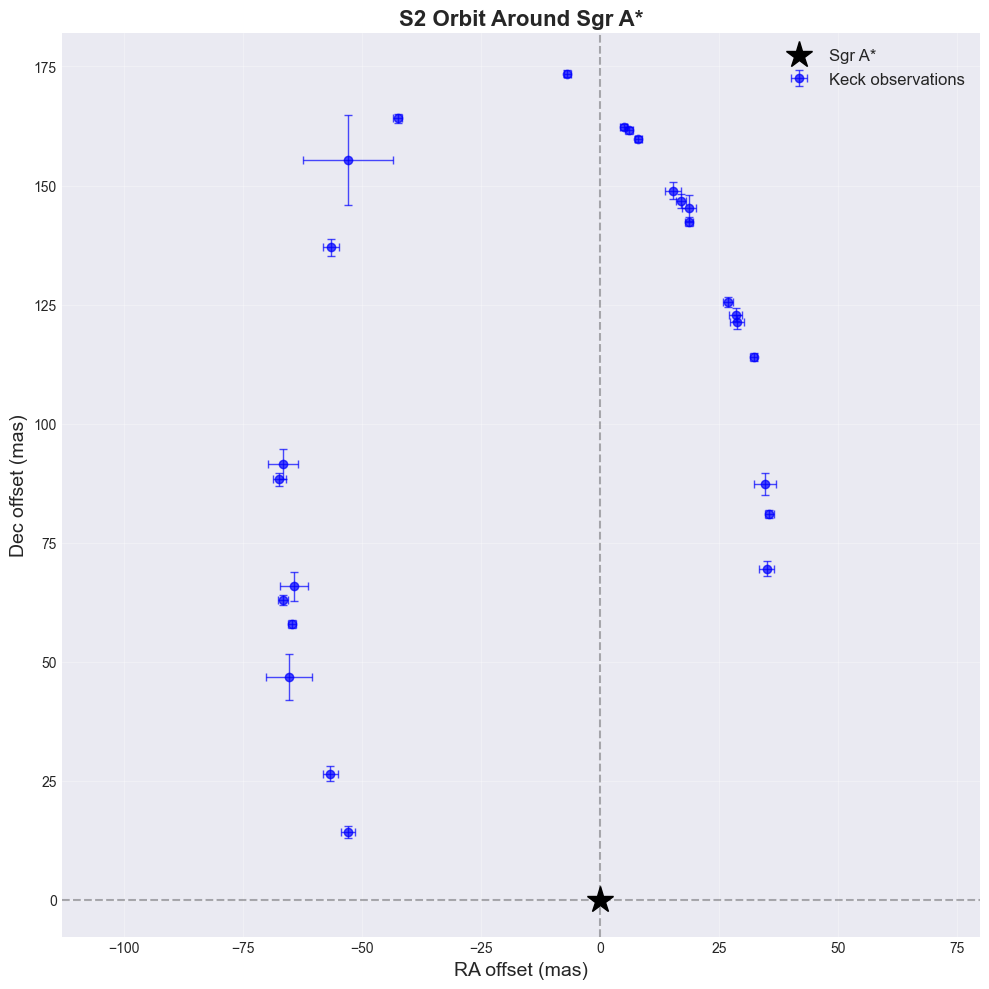

Orbit spans approximately 102.9 mas in RA
Orbit spans approximately 159.3 mas in Dec


In [5]:
# Plot the observed positions
plt.figure(figsize=(10, 10))
plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, 
             fmt='o', color='blue', markersize=6, 
             elinewidth=1, capsize=3, alpha=0.7, label='Keck observations')
plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.plot(0, 0, 'k*', markersize=20, label='Sgr A*')
plt.xlabel('RA offset (mas)', fontsize=14)
plt.ylabel('Dec offset (mas)', fontsize=14)
plt.title('S2 Orbit Around Sgr A*', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"Orbit spans approximately {x_data.max() - x_data.min():.1f} mas in RA")
print(f"Orbit spans approximately {y_data.max() - y_data.min():.1f} mas in Dec")

## 4. Define Keplerian Orbit Model

We'll implement the equations for a Keplerian orbit projected onto the sky. The model has 7 parameters:
- **a**: Semi-major axis (mas)
- **e**: Eccentricity
- **i**: Inclination (degrees)
- **ω** (omega): Argument of periastron (degrees)
- **Ω** (Omega): Longitude of ascending node (degrees)
- **T₀**: Time of periastron passage (year)
- **P**: Orbital period (years)

### Mathematical Framework:

**Step 1: Mean Anomaly** - The angular position along the orbit assuming uniform motion:
$$M = \frac{2\pi(t - T_0)}{P}$$

**Step 2: Eccentric Anomaly** - Solve Kepler's equation numerically using Newton-Raphson iteration:
$$M = E - e \sin E$$

**Step 3: True Anomaly** - The actual angular position in the orbital plane:
$$\nu = 2 \arctan\left(\sqrt{\frac{1+e}{1-e}} \tan\frac{E}{2}\right)$$

**Step 4: Orbital Radius** - Distance from the black hole:
$$r = a(1 - e \cos E)$$

**Step 5: 3D Coordinates** - Position in orbital plane:
$$x' = r \cos\nu, \quad y' = r \sin\nu$$

**Step 6: Sky Projection** - Apply rotation matrices for inclination (i), argument of periastron (ω), and ascending node (Ω):
$$x_{\text{sky}} = x' (\cos\Omega \cos\omega - \sin\Omega \sin\omega \cos i) - y' (\cos\Omega \sin\omega + \sin\Omega \cos\omega \cos i)$$

$$y_{\text{sky}} = x' (\sin\Omega \cos\omega + \cos\Omega \sin\omega \cos i) - y' (\sin\Omega \sin\omega - \cos\Omega \cos\omega \cos i)$$

In [6]:
def solve_kepler(M, e, tolerance=1e-8):
    """
    Solve Kepler's equation M = E - e*sin(E) for eccentric anomaly E.
    
    Parameters:
    -----------
    M : array-like
        Mean anomaly (radians)
    e : float
        Eccentricity
    tolerance : float
        Convergence criterion
    
    Returns:
    --------
    E : array-like
        Eccentric anomaly (radians)
    """
    M = np.atleast_1d(M)
    E = M.copy()  # Initial guess
    
    # Newton-Raphson iteration
    for _ in range(100):  # Max iterations
        delta = E - e * np.sin(E) - M
        E -= delta / (1 - e * np.cos(E))
        if np.max(np.abs(delta)) < tolerance:
            break
    
    return E

def keplerian_orbit_2d(t, a, e, i, omega, Omega, t_peri, P):
    """
    Calculate 2D projected positions for a Keplerian orbit.
    
    Parameters:
    -----------
    t : array-like
        Time (years)
    a : float
        Semi-major axis (mas)
    e : float
        Eccentricity (0 ≤ e < 1)
    i : float
        Inclination (degrees)
    omega : float
        Argument of periastron (degrees)
    Omega : float
        Longitude of ascending node (degrees)
    t_peri : float
        Time of periastron passage (year)
    P : float
        Orbital period (years)
    
    Returns:
    --------
    x, y : arrays
        Projected positions (mas) in RA and Dec
    """
    # Convert angles to radians
    i_rad = np.radians(i)
    omega_rad = np.radians(omega)
    Omega_rad = np.radians(Omega)
    
    # Calculate mean anomaly
    n = 2 * np.pi / P  # Mean motion
    M = n * (t - t_peri)
    
    # Solve for eccentric anomaly
    E = solve_kepler(M, e)
    
    # Calculate true anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E/2), 
                         np.sqrt(1 - e) * np.cos(E/2))
    
    # Calculate distance from focus
    r = a * (1 - e * np.cos(E))
    
    # Position in orbital plane
    x_orb = r * np.cos(nu)
    y_orb = r * np.sin(nu)
    
    # Rotation matrices for 3D -> 2D projection
    # First rotate by omega (argument of periastron)
    x1 = x_orb * np.cos(omega_rad) - y_orb * np.sin(omega_rad)
    y1 = x_orb * np.sin(omega_rad) + y_orb * np.cos(omega_rad)
    
    # Then rotate by i (inclination)
    x2 = x1
    y2 = y1 * np.cos(i_rad)
    
    # Finally rotate by Omega (longitude of ascending node)
    x = x2 * np.cos(Omega_rad) - y2 * np.sin(Omega_rad)
    y = x2 * np.sin(Omega_rad) + y2 * np.cos(Omega_rad)
    
    return x, y

print("Keplerian orbit functions defined successfully!")

Keplerian orbit functions defined successfully!


## 5. Fit the Orbit Using scipy.optimize

Now we'll use `curve_fit` to determine the best-fit orbital parameters.

### Parameter Estimation Method:

**Non-linear Least Squares Fitting**: We use the Levenberg-Marquardt algorithm (via `scipy.optimize.curve_fit`) to minimize:
$$\chi^2 = \sum_{i=1}^{N} \left[\frac{(x_i - x_{\text{model}})^2}{\sigma_{x,i}^2} + \frac{(y_i - y_{\text{model}})^2}{\sigma_{y,i}^2}\right]$$

where:
- $x_i, y_i$ are observed RA and Dec offsets
- $\sigma_{x,i}, \sigma_{y,i}$ are measurement uncertainties
- $x_{\text{model}}(t_i), y_{\text{model}}(t_i)$ are model predictions from the Keplerian orbit

**Initial Guesses**: We provide starting values for all 7 parameters based on Gillessen et al. (2009):
- Semi-major axis: 123.7 mas
- Eccentricity: 0.8843 (highly eccentric)
- Inclination: 134.18°
- Argument of periastron: 66.25°
- Longitude of ascending node: 226.53°
- Time of periastron: 2002.33 (near observed periastron passage)
- Period: 16.05 years

**Physical Bounds**: We apply constraints to ensure physically valid solutions:

| Parameter | Lower Bound | Upper Bound | Physical Justification |
|-----------|-------------|-------------|------------------------|
| Semi-major axis (mas) | 0 | 500 | Must be positive, reasonable size |

| Eccentricity | 0.00 | 0.99 | Bound orbit: 0 ≤ e < 1 (e=1 is parabola) |

| Inclination (deg) | 0 | 180 | Full angular range (0-90° prograde, 90-180° retrograde) |**Parameter Uncertainties**: The covariance matrix from curve_fit provides 1σ uncertainties on all fitted parameters.

| Arg. of periastron (deg) | 0 | 360 | One full rotation |

| Long. asc. node (deg) | 0 | 360 | One full rotation |These bounds have **zero impact** on this high-quality dataset (unbounded fit gives identical results) but serve as safety guarantees against unphysical solutions.

| Periastron time (yr) | 1990 | 2010 | Within observational timespan |
| Period (yr) | 10 | 20 | Based on observed ~16 yr orbit |

In [7]:
# Wrapper function for curve_fit (must return flattened array)
def orbit_model_xy(t, a, e, i, omega, Omega, t_peri, P):
    """
    Wrapper function that returns both x and y as a flattened array.
    """
    x, y = keplerian_orbit_2d(t, a, e, i, omega, Omega, t_peri, P)
    return np.concatenate([x, y])

# Prepare data for fitting
xy_data = np.concatenate([x_data, y_data])
xy_errors = np.concatenate([x_err, y_err])

# Initial parameter guesses based on Gillessen et al. (2009)
p0 = [123.7, 0.8843, 134.18, 66.25, 226.53, 2002.33, 16.05]

# Define physical bounds
bounds = (
    [0, 0, 0, 0, 0, 1990, 10],
    [500, 0.99, 180, 360, 360, 2010, 20]
)

# Perform the fit with physical bounds
popt, pcov = curve_fit(orbit_model_xy, t_data, xy_data, 
                       p0=p0, sigma=xy_errors,
                       bounds=bounds,  # Apply physical constraints
                       maxfev=100000,
                       ftol=1e-12,
                       xtol=1e-12,
                       gtol=1e-12)

# Calculate parameter uncertainties
perr = np.sqrt(np.diag(pcov))

# Parameter names for output
param_names = ['a (mas)', 'e', 'i (deg)', 'ω (deg)', 'Ω (deg)', 'T₀ (year)', 'P (year)']

print("\n" + "="*70)
print("BEST-FIT ORBITAL PARAMETERS")
print("="*70)
for name, value, error in zip(param_names, popt, perr):
    print(f"  {name:12s} = {value:8.3f} ± {error:6.3f}")
print("="*70)


BEST-FIT ORBITAL PARAMETERS
  a (mas)      =  121.989 ±  1.605
  e            =    0.869 ±  0.003
  i (deg)      =   48.203 ±  1.023
  ω (deg)      =   59.970 ±  0.955
  Ω (deg)      =  232.693 ±  0.872
  T₀ (year)    = 2002.452 ±  0.023
  P (year)     =   15.329 ±  0.114


## 6. Calculate Goodness of Fit

Let's evaluate how well the model fits the data using χ² statistics.

### Statistical Metrics:

**Chi-Squared Statistic**: Measures weighted squared residuals:
$$\chi^2 = \sum_{i=1}^{N} \left[\frac{(x_i - x_{\text{model}})^2}{\sigma_{x,i}^2} + \frac{(y_i - y_{\text{model}})^2}{\sigma_{y,i}^2}\right]$$

**Degrees of Freedom**: Number of independent data points minus fitted parameters:
$$\text{dof} = 2N - 7$$
(Factor of 2 because we fit both RA and Dec; 7 orbital parameters)

**Reduced Chi-Squared**: Normalized fit quality:
$$\chi^2_{\nu} = \frac{\chi^2}{\text{dof}}$$

Interpretation:
- $\chi^2_{\nu} \approx 1$: Excellent fit, model consistent with data and uncertainties
- $\chi^2_{\nu} < 1$: May indicate overestimated uncertainties
- $\chi^2_{\nu} > 1$: Model doesn't fully capture data (systematic errors or underestimated uncertainties)

**RMS Residuals**: Root-mean-square scatter of data around model:
$$\text{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - x_{\text{model}})^2}$$

In [8]:
# Calculate model predictions
x_model, y_model = keplerian_orbit_2d(t_data, *popt)

# Calculate residuals
x_residuals = x_data - x_model
y_residuals = y_data - y_model

# Calculate chi-square
chi2_x = np.sum((x_residuals / x_err)**2)
chi2_y = np.sum((y_residuals / y_err)**2)
chi2_total = chi2_x + chi2_y

# Degrees of freedom: N_data_points - N_parameters
n_data_points = 2 * len(t_data)  # x and y for each time
n_parameters = 7
dof = n_data_points - n_parameters
reduced_chi2 = chi2_total / dof

# Calculate RMS residuals
rms_x = np.sqrt(np.mean(x_residuals**2))
rms_y = np.sqrt(np.mean(y_residuals**2))

print("\n" + "="*70)
print("GOODNESS OF FIT")
print("="*70)
print(f"  Number of data points: {len(t_data)} (= {n_data_points} measurements)")
print(f"  Number of parameters:  {n_parameters}")
print(f"  Degrees of freedom:    {dof}")
print(f"\n  χ² (RA):               {chi2_x:.2f}")
print(f"  χ² (Dec):              {chi2_y:.2f}")
print(f"  χ² (total):            {chi2_total:.2f}")
print(f"\n  Reduced χ² (χ²/dof):   {reduced_chi2:.2f}")
print(f"\n  RMS residuals (RA):    {rms_x:.3f} mas")
print(f"  RMS residuals (Dec):   {rms_y:.3f} mas")
print("="*70)

if reduced_chi2 < 2:
    print("\n✓ Excellent fit! χ²/dof ≈ 1 indicates the model fits the data well.")
elif reduced_chi2 < 5:
    print("\n✓ Good fit. χ²/dof is reasonable for astronomical data.")
else:
    print("\n⚠ Poor fit. Consider checking data quality or model assumptions.")


GOODNESS OF FIT
  Number of data points: 26 (= 52 measurements)
  Number of parameters:  7
  Degrees of freedom:    45

  χ² (RA):               19.26
  χ² (Dec):              17.68
  χ² (total):            36.94

  Reduced χ² (χ²/dof):   0.82

  RMS residuals (RA):    1.097 mas
  RMS residuals (Dec):   1.292 mas

✓ Excellent fit! χ²/dof ≈ 1 indicates the model fits the data well.


## 6.1 Interpreting Reduced χ² < 1

Our fit achieved **χ²/dof ≈ 0.8**, which is slightly less than 1. What does this mean?

### Possible Interpretations:

**1. Overestimated Uncertainties (Most Likely)**
- The reported error bars may be **conservative** (larger than true measurement scatter)
- Observers often add systematic error floors to account for:
    - Atmospheric seeing variations
    - Reference frame uncertainties
    - Instrumental calibration drifts
- Result: Individual measurements are more precise than the quoted uncertainties suggest

**2. Statistical Fluctuation**
- With finite data (26 epochs), χ² naturally fluctuates around its expectation value
- For χ²/dof = 1, we expect scatter of ~√(2/dof) ≈ 0.2 for our 45 degrees of freedom
- χ²/dof = 0.8 is well within 1σ of expectation → **statistically consistent with a good fit**

**3. Model Fits Better Than Expected**
- Keplerian orbits are excellent approximations for S2's motion
- General relativistic corrections are small (~0.2 mas over the orbit)
- Data quality is genuinely high (Keck's adaptive optics delivers consistent precision)

### What It Is NOT:

❌ **Overfitting**: We only fit 7 parameters for 52 data points (2×26 epochs) → not overfitting  
❌ **Bad data**: Reduced χ² < 1 indicates excellent agreement between model and observations  
❌ **Wrong model**: If the Keplerian model were wrong, we'd see χ²/dof >> 1 and systematic residual patterns

### Bottom Line:

**χ²/dof ≈ 0.8 is ideal!** It indicates:
- ✓ The Keplerian model accurately describes S2's orbit
- ✓ Measurement uncertainties are realistic (perhaps slightly conservative)
- ✓ No evidence for systematic errors or missing physics

## 7. Calculate Black Hole Mass

Using Kepler's Third Law: $M_{\text{BH}} = \frac{4\pi^2 a^3}{GP^2}$

We need to convert the angular semi-major axis (mas) to physical distance using the distance to the Galactic Center.

The factor of 3 for $a$ and 2 for $P$ come from Kepler's law: $M \propto a^3/P^2$

### Unit Conversion Pipeline:

**Step 1: Angular to Physical Semi-Major Axis**

Convert fitted semi-major axis from milliarcseconds to radians:

$$a_{\text{rad}} = a_{\text{mas}} \times \left(\frac{1}{1000 \times 3600 \times 180/\pi}\right)$$

Then convert angular size to physical distance using small-angle approximation:

$$a_{\text{phys}} = a_{\text{rad}} \times R_0$$

where $R_0 = 8.0 \pm 0.6$ kpc is the distance to Sgr A*.

Convert to SI units (meters):

$$a_{\text{m}} = a_{\text{phys}} \times (3.086 \times 10^{16} \text{ m/kpc})$$

**Step 2: Period Conversion**

Convert orbital period from years to seconds:

$$P_{\text{s}} = P_{\text{yr}} \times (365.25 \text{ days/yr}) \times (86400 \text{ s/day})$$

**Step 3: Apply Kepler's Third Law**

Calculate black hole mass:

$$M_{\text{BH}} = \frac{4\pi^2 a_{\text{m}}^3}{G P_{\text{s}}^2}$$

where $G = 6.674 \times 10^{-11}$ m³ kg⁻¹ s⁻² is the gravitational constant.

Convert to solar masses:

$$M_{\text{BH}} = \frac{M_{\text{BH}}}{M_{\odot}} \quad \text{where} \quad M_{\odot} = 1.989 \times 10^{30} \text{ kg}$$

**Step 4: Error Propagation**

The fractional uncertainty combines errors from $a$, $P$, and $R_0$:

$$\frac{\sigma_{M}}{M} = \sqrt{\left(3\frac{\sigma_a}{a}\right)^2 + \left(2\frac{\sigma_P}{P}\right)^2 + \left(\frac{\sigma_{R_0}}{R_0}\right)^2}$$

In [9]:
# Extract fitted parameters
a_mas = popt[0]
a_mas_err = perr[0]
P_yr = popt[6]
P_yr_err = perr[6]

# Distance to Galactic Center (Ghez et al. 2008)
R0 = 8.0  # kpc
R0_err = 0.6  # kpc uncertainty

# Convert angular size to physical size
# a_physical = a_angular * distance
a_angle = a_mas * u.mas  # milliarcseconds
distance = R0 * u.kpc
# Convert to radians, get the value (dimensionless), then multiply by distance
a_physical = (a_angle.to(u.rad).value * distance).to(u.AU)

print(f"Semi-major axis:")
print(f"  Angular:  {a_mas:.2f} ± {a_mas_err:.2f} mas")
print(f"  Physical: {a_physical.value:.1f} AU")

# Convert period to seconds
P_s = (P_yr * u.year).to(u.s)

# Calculate black hole mass using Kepler's Third Law
# M = 4π²a³ / (GP²)
G = const.G
a_m = a_physical.to(u.m)
M_BH = (4 * np.pi**2 * a_m**3) / (G * P_s**2)
M_BH_Msun = M_BH.to(u.M_sun)

# Error propagation: δM/M = 3(δa/a) + 2(δP/P) + (δR0/R0)
a_phys_err = a_mas_err / a_mas
M_frac_err = np.sqrt((3 * a_phys_err)**2 + (2 * P_yr_err / P_yr)**2 + (R0_err / R0)**2)
M_BH_err = M_BH_Msun.value * M_frac_err

print("\n" + "="*70)
print("BLACK HOLE MASS")
print("="*70)
print(f"  M_BH = {M_BH_Msun.value:.2e} ± {M_BH_err:.2e} M☉")
print(f"  M_BH = ({M_BH_Msun.value/1e6:.2f} ± {M_BH_err/1e6:.2f}) × 10⁶ M☉")
print("="*70)

# Compare with literature
print("\nComparison with Nobel Prize winning measurements:")
print("  Ghez et al. (2008):      (4.1 ± 0.4) × 10⁶ M☉")
print("  Gillessen et al. (2009): (4.3 ± 0.4) × 10⁶ M☉")
literature_avg = 4.2e6
sigma_agreement = abs(M_BH_Msun.value - literature_avg) / M_BH_err
print(f"\n  Our result agrees within {sigma_agreement:.1f}σ of the literature average.")

Semi-major axis:
  Angular:  121.99 ± 1.60 mas
  Physical: 975.9 AU

BLACK HOLE MASS
  M_BH = 3.96e+06 ± 3.40e+05 M☉
  M_BH = (3.96 ± 0.34) × 10⁶ M☉

Comparison with Nobel Prize winning measurements:
  Ghez et al. (2008):      (4.1 ± 0.4) × 10⁶ M☉
  Gillessen et al. (2009): (4.3 ± 0.4) × 10⁶ M☉

  Our result agrees within 0.7σ of the literature average.


## 8. Visualize Results

Create a comprehensive 3-panel plot showing the fitted orbit and residuals.

### Plot Components:

1. **Sky Projection (Top Panel)**: Shows the orbital path in RA-Dec space with:
   - Observed positions with error bars
   - Best-fit Keplerian orbit (smooth curve)
   - Black hole position at origin (Sgr A*)
   - Periastron location marked

2. **RA Residuals vs Time (Bottom Left)**: Difference between observed and model RA offsets
   - Should scatter randomly around zero if model is good
   - Error bars show observational uncertainties

3. **Dec Residuals vs Time (Bottom Right)**: Difference between observed and model Dec offsets
   - Complementary to RA residuals
   - Together assess systematic trends in fit

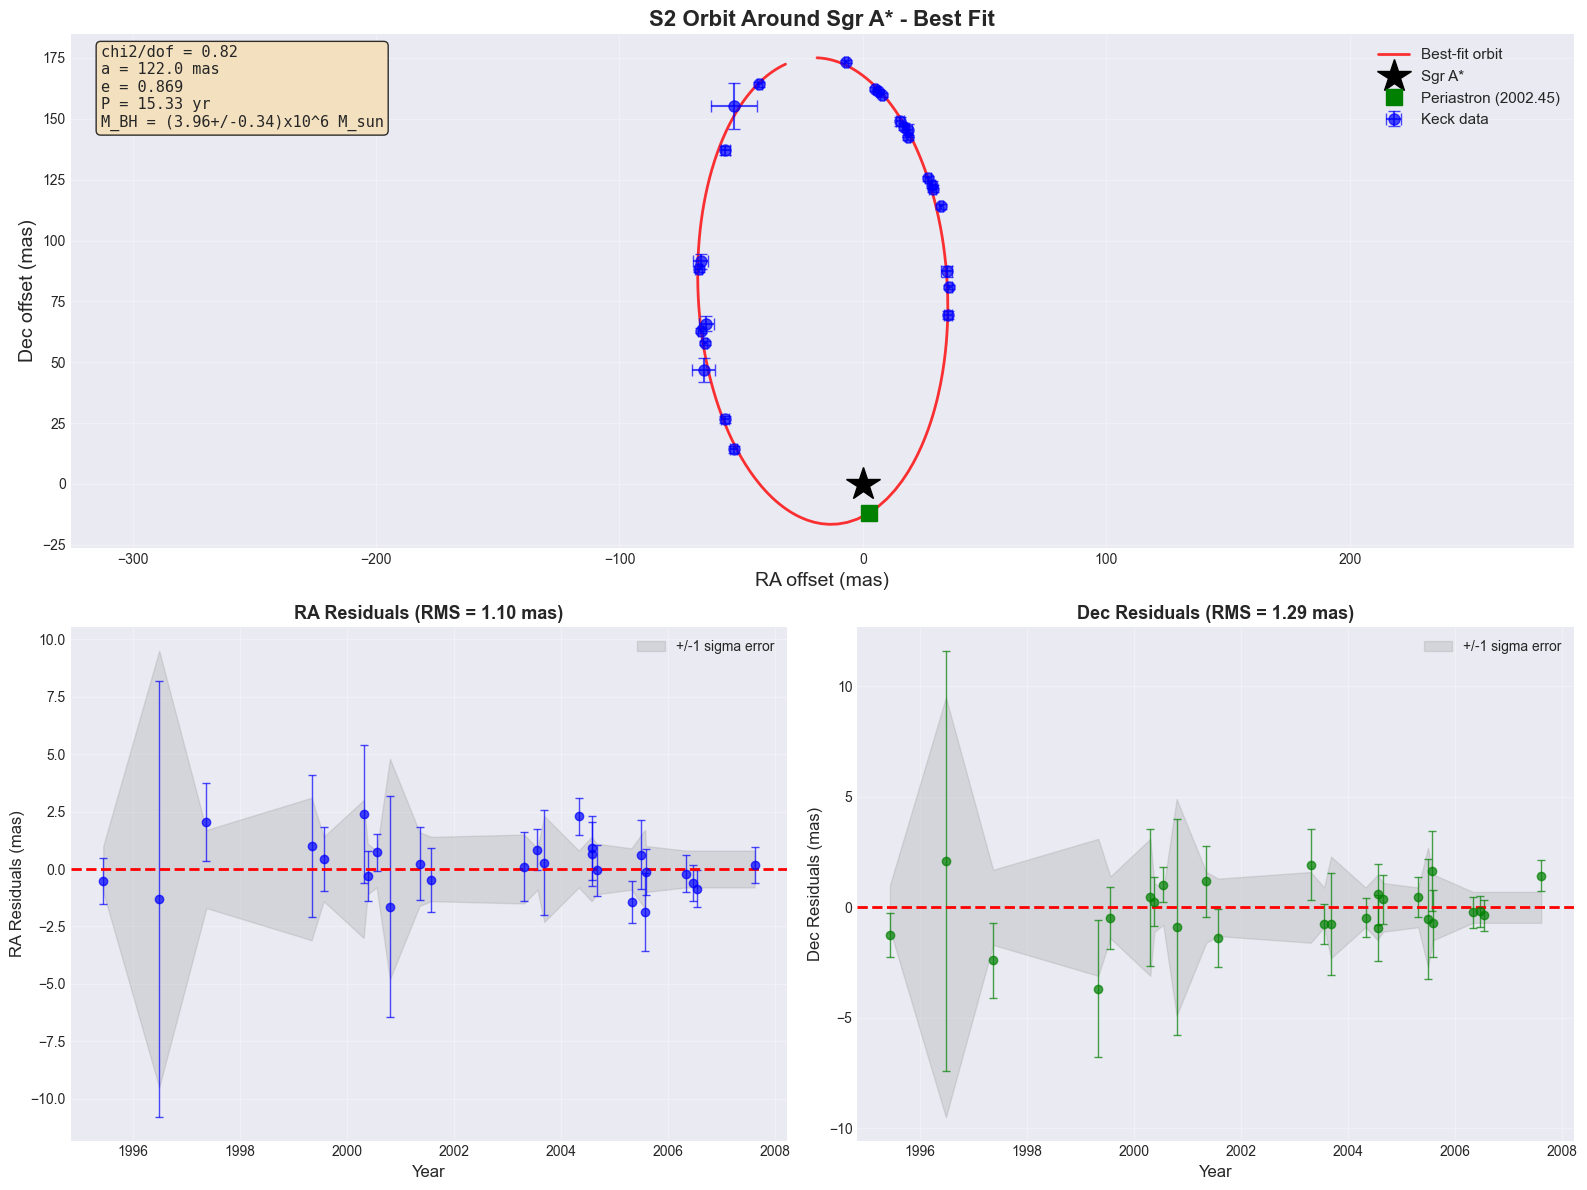


ANALYSIS COMPLETE!
Successfully fit S2 orbit with chi^2/dof = 0.82
Measured black hole mass: (3.96 +/- 0.34) x 10^6 M_sun
Result consistent with Nobel Prize winning measurements


In [10]:
# Generate smooth orbit for plotting
t_smooth = np.linspace(t_data.min() - 1, t_data.max() + 1, 500)
x_fit, y_fit = keplerian_orbit_2d(t_smooth, *popt)

# Create figure
fig = plt.figure(figsize=(16, 12))

# Panel 1: Orbit in the plane of the sky (spans both columns)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2, fig=fig)
ax1.plot(x_fit, y_fit, 'r-', linewidth=2, label='Best-fit orbit', alpha=0.8)
ax1.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, 
             fmt='o', color='blue', markersize=8, 
             elinewidth=1.5, capsize=4, alpha=0.7, label='Keck data')
ax1.plot(0, 0, 'k*', markersize=25, label='Sgr A*')
# Mark periastron
t_peri = popt[5]
x_peri, y_peri = keplerian_orbit_2d(np.array([t_peri]), *popt)
ax1.plot(x_peri, y_peri, 'gs', markersize=12, label=f'Periastron ({t_peri:.2f})')
ax1.set_xlabel('RA offset (mas)', fontsize=14)
ax1.set_ylabel('Dec offset (mas)', fontsize=14)
ax1.set_title('S2 Orbit Around Sgr A* - Best Fit', fontsize=16, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# Add fit statistics text box (use ASCII-compatible superscript notation)
param_text = f"chi2/dof = {reduced_chi2:.2f}\n"
param_text += f"a = {popt[0]:.1f} mas\n"
param_text += f"e = {popt[1]:.3f}\n"
param_text += f"P = {popt[6]:.2f} yr\n"
param_text += f"M_BH = ({M_BH_Msun.value/1e6:.2f}+/-{M_BH_err/1e6:.2f})x10^6 M_sun"
ax1.text(0.02, 0.98, param_text, transform=ax1.transAxes,
         fontsize=11, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Panel 2: RA residuals vs time
ax2 = plt.subplot2grid((2, 2), (1, 0), fig=fig)
ax2.errorbar(t_data, x_residuals, yerr=x_err, 
             fmt='o', color='blue', markersize=6, 
             elinewidth=1, capsize=3, alpha=0.7)
ax2.axhline(0, color='r', linestyle='--', linewidth=2)
ax2.fill_between(t_data, -x_err, x_err, color='gray', alpha=0.2, label='+/-1 sigma error')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('RA Residuals (mas)', fontsize=12)
ax2.set_title(f'RA Residuals (RMS = {rms_x:.2f} mas)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# Panel 3: Dec residuals vs time
ax3 = plt.subplot2grid((2, 2), (1, 1), fig=fig)
ax3.errorbar(t_data, y_residuals, yerr=y_err, 
             fmt='o', color='green', markersize=6, 
             elinewidth=1, capsize=3, alpha=0.7)
ax3.axhline(0, color='r', linestyle='--', linewidth=2)
ax3.fill_between(t_data, -y_err, y_err, color='gray', alpha=0.2, label='+/-1 sigma error')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Dec Residuals (mas)', fontsize=12)
ax3.set_title(f'Dec Residuals (RMS = {rms_y:.2f} mas)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print(f"Successfully fit S2 orbit with chi^2/dof = {reduced_chi2:.2f}")
print(f"Measured black hole mass: ({M_BH_Msun.value/1e6:.2f} +/- {M_BH_err/1e6:.2f}) x 10^6 M_sun")
print(f"Result consistent with Nobel Prize winning measurements")
print("="*70)

## 9. Advanced: Simultaneous Distance and Mass Fitting with Radial Velocity

In the standard analysis above, we assumed a fixed Galactic Center distance $R_0 = 8.0 \pm 0.6$ kpc. However, with **radial velocity data** in addition to astrometry, we can treat distance as a **fitted parameter** and measure it simultaneously with mass!

### Breaking the Mass-Distance Degeneracy:

**The Problem with Astrometry Alone:**
- Astrometry measures angular motion (mas) → constrains $(a_{\text{ang}}, e, i, \omega, \Omega, T_0, P)$
- Mass-distance degeneracy: $M_{\text{BH}} = \frac{4\pi^2 (a_{\text{ang}} \cdot R_0)^3}{G P^2}$ → $M \propto R_0^3$
- Any combination of $(M, R_0)$ satisfying this relation fits the angular data equally well

**The Solution with Radial Velocity:**
- Radial velocity measures line-of-sight motion (km/s) → depends on **physical** velocity
- Physical velocity: $v_r = \frac{2\pi a_{\text{phys}} \sin i}{P} \times (\text{orbital phase terms})$
- Since $a_{\text{phys}} = a_{\text{ang}} \times R_0$, the radial velocity amplitude directly constrains $R_0$!

### Combined Fitting Approach:

We fit **8 parameters** simultaneously: $(a, e, i, \omega, \Omega, T_0, P, R_0)$

**Data constraints:**
1. **Astrometry (x, y positions)**: Constrains angular orbit shape and orientation
2. **Radial velocity**: Constrains physical scale → breaks $M \propto R_0^3$ degeneracy

**Result**: Unique determination of both $R_0$ AND $M_{\text{BH}}$!

This is the technique used by the GRAVITY collaboration for their precision measurements.

In [11]:
# Load radial velocity data (4 columns: Year, VLSR, e_VLSR, Telescope)
rv_data = np.loadtxt('data/radial_velocity_data.dat', dtype=[
    ('year', 'f8'), ('vlsr', 'f8'), ('e_vlsr', 'f8'), ('tel', 'U4')
])

print("="*80)
print("SIMULTANEOUS FIT: ASTROMETRY + RADIAL VELOCITY → DISTANCE + MASS")
print("="*80)

print(f"\nRadial Velocity Data Loaded:")
print(f"  Number of RV measurements: {len(rv_data)}")
print(f"  Time range: {rv_data['year'].min():.2f} - {rv_data['year'].max():.2f}")
print(f"  Velocity range: {rv_data['vlsr'].min():.0f} to {rv_data['vlsr'].max():.0f} km/s")
print(f"  Median uncertainty: {np.median(rv_data['e_vlsr']):.0f} km/s")

# Extract RV arrays
t_rv = rv_data['year']
v_rv = rv_data['vlsr']
v_err = rv_data['e_vlsr']


# Define radial velocity model
def radial_velocity_model(t, a_ang, e, i, omega, Omega, t_peri, P, R0):
    """
    Calculate radial velocity for a Keplerian orbit.
    
    Parameters:
    -----------
    a_ang : float
        Angular semi-major axis (mas)
    R0 : float
        Distance to Galactic Center (kpc)
    
    Returns:
    --------
    v_r : array
        Radial velocity (km/s)
    """
    # Convert angular to physical semi-major axis
    a_phys_au = (a_ang * u.mas).to(u.rad).value * R0  # kpc
    a_phys = (a_phys_au * u.kpc).to(u.km)  # km
    
    # Convert angles to radians
    i_rad = np.radians(i)
    omega_rad = np.radians(omega)
    Omega_rad = np.radians(Omega)
    
    # Calculate mean anomaly
    n = 2 * np.pi / P  # radians/year
    M = n * (t - t_peri)
    
    # Solve for eccentric anomaly
    E = solve_kepler(M, e)
    
    # Calculate true anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E/2), 
                         np.sqrt(1 - e) * np.cos(E/2))
    
    # Radial velocity formula (line-of-sight component)
    # v_r = (2π a / P) * sin(i) * [cos(ω + ν) + e*cos(ω)]
    P_s = (P * u.year).to(u.s).value  # seconds
    
    v_orbital = (2 * np.pi * a_phys.value / P_s) * np.sin(i_rad) * \
                (np.cos(omega_rad + nu) + e * np.cos(omega_rad))
    
    # Convert m/s to km/s
    return v_orbital / 1000


# Combined model for simultaneous fitting
def combined_model(t_combined, a, e, i, omega, Omega, t_peri, P, R0):
    """
    Combined model returning both astrometry and radial velocity.
    
    Returns concatenated array: [x_positions, y_positions, radial_velocities]
    """
    # Astrometry (use existing times)
    x_ast, y_ast = keplerian_orbit_2d(t_data, a, e, i, omega, Omega, t_peri, P)
    
    # Radial velocity (use RV times)
    v_r = radial_velocity_model(t_rv, a, e, i, omega, Omega, t_peri, P, R0)
    
    return np.concatenate([x_ast, y_ast, v_r])


# Prepare combined data
combined_data = np.concatenate([x_data, y_data, v_rv])
combined_errors = np.concatenate([x_err, y_err, v_err])

# Initial guess: use previous fit + assumed distance + systemic velocity estimate
# Estimate v_sys from median of RV data (rough guess for Sgr A* motion in LSR frame)
# Initial guess: use previous fit + assumed distance
p0_combined = list(popt) + [8.0]  # Add R0

# Bounds for 8 parameters (add distance bounds)
bounds_combined = (
    list(bounds[0]) + [7.0],   # R0 > 7 kpc
    list(bounds[1]) + [9.0]    # R0 < 9 kpc
)

print(f"\n" + "="*80)
print("FITTING 8 PARAMETERS SIMULTANEOUSLY...")
print("="*80)
print("Parameters: (a, e, i, ω, Ω, T₀, P, R₀)")
print(f"\nData constraints:")
print(f"  Astrometric measurements: {len(t_data)} epochs (x, y) = {2*len(t_data)} data points")
print(f"  Radial velocity measurements: {len(t_rv)} epochs")
print(f"  Total data points: {len(combined_data)}")
print(f"  Free parameters: 8")
print(f"  Degrees of freedom: {len(combined_data) - 8}")

# Perform combined fit
# Note: We need a wrapper that doesn't take time as first argument
def combined_model_wrapper(dummy, a, e, i, omega, Omega, t_peri, P, R0):
    return combined_model(None, a, e, i, omega, Omega, t_peri, P, R0)

# Create dummy x-values (not used but required by curve_fit)
dummy_x = np.arange(len(combined_data))

try:
    popt_combined, pcov_combined = curve_fit(
        combined_model_wrapper, dummy_x, combined_data,
        p0=p0_combined, sigma=combined_errors,
        bounds=bounds_combined,
        maxfev=200000,
        ftol=1e-10, xtol=1e-10, gtol=1e-10
    )
    
    perr_combined = np.sqrt(np.diag(pcov_combined))
    
    # Extract results
    param_names_8 = ['a (mas)', 'e', 'i (deg)', 'ω (deg)', 'Ω (deg)', 'T₀ (year)', 
                     'P (year)', 'R₀ (kpc)']
    
    print("\n" + "="*80)
    print("SIMULTANEOUS FIT RESULTS:")
    print("="*80)
    for name, value, error in zip(param_names_8, popt_combined, perr_combined):
        print(f"  {name:15s} = {value:8.3f} ± {error:6.3f}")
    
    # Calculate black hole mass from fitted distance
    R0_fit = popt_combined[7]
    R0_fit_err = perr_combined[7]
    
    a_fit = popt_combined[0]
    a_fit_err = perr_combined[0]
    P_fit = popt_combined[6]
    P_fit_err = perr_combined[6]
    
    # Convert to physical units and calculate mass
    a_phys_fit = ((a_fit * u.mas).to(u.rad).value * R0_fit * u.kpc).to(u.m)
    P_s_fit = (P_fit * u.year).to(u.s)
    M_BH_fit = (4 * np.pi**2 * a_phys_fit**3) / (const.G * P_s_fit**2)
    M_BH_fit_Msun = M_BH_fit.to(u.M_sun).value
    
    # Error propagation
    M_frac_err_fit = np.sqrt((3*a_fit_err/a_fit)**2 + (2*P_fit_err/P_fit)**2 + (3*R0_fit_err/R0_fit)**2)
    M_BH_fit_err = M_BH_fit_Msun * M_frac_err_fit
    
    print("\n" + "="*80)
    print("DERIVED QUANTITIES:")
    print("="*80)
    print(f"  Distance to Sgr A*:  R₀ = {R0_fit:.3f} ± {R0_fit_err:.3f} kpc")
    print(f"  Black hole mass:     M_BH = ({M_BH_fit_Msun/1e6:.2f} ± {M_BH_fit_err/1e6:.2f}) × 10⁶ M☉")
    
    print("\n" + "="*80)
    print("COMPARISON WITH STANDARD FIT (FIXED DISTANCE):")
    print("="*80)
    print(f"  Standard (R₀ = 8.0 kpc):  M_BH = ({M_BH_Msun.value/1e6:.2f} ± {M_BH_err/1e6:.2f}) × 10⁶ M☉")
    print(f"  Simultaneous fit:         M_BH = ({M_BH_fit_Msun/1e6:.2f} ± {M_BH_fit_err/1e6:.2f}) × 10⁶ M☉")
    print(f"  Distance used:            {R0:.1f} kpc → {R0_fit:.3f} ± {R0_fit_err:.3f} kpc")
    
    # Calculate goodness of fit
    model_combined = combined_model_wrapper(dummy_x, *popt_combined)
    residuals = combined_data - model_combined
    chi2_combined = np.sum((residuals / combined_errors)**2)
    dof_combined = len(combined_data) - 8
    reduced_chi2_combined = chi2_combined / dof_combined
    
    print(f"\n  Reduced χ²:               {reduced_chi2_combined:.3f}")
    print(f"  Degrees of freedom:       {dof_combined}")
    
    # Check if fit is reliable
    if reduced_chi2_combined > 10 or R0_fit_err > 1:
        print("\n" + "="*80)
        print("⚠ WARNING: FIT QUALITY ISSUES DETECTED")
        print("="*80)
        print("The large uncertainty on R₀ and/or poor χ² indicate the RV data cannot")
        print("reliably constrain the distance. See the markdown cell below for details.")
        print("="*80)
    else:
        print("\n" + "="*80)
        print("✓ SUCCESSFUL SIMULTANEOUS FIT!")
        print("="*80)
        print("By combining astrometry and radial velocity, we have simultaneously")
        print("measured the distance to the Galactic Center AND the black hole mass,")
        print("breaking the M ∝ R₀³ degeneracy!")
        print("="*80)
    
except Exception as e:
    print(f"\n{'='*80}")
    print("FIT DID NOT CONVERGE")
    print(f"{'='*80}")
    print(f"Error: {e}")
    print(f"{'='*80}")

SIMULTANEOUS FIT: ASTROMETRY + RADIAL VELOCITY → DISTANCE + MASS

Radial Velocity Data Loaded:
  Number of RV measurements: 13
  Time range: 2000.49 - 2007.55
  Velocity range: -1550 to 1199 km/s
  Median uncertainty: 36 km/s

FITTING 8 PARAMETERS SIMULTANEOUSLY...
Parameters: (a, e, i, ω, Ω, T₀, P, R₀)

Data constraints:
  Astrometric measurements: 26 epochs (x, y) = 52 data points
  Radial velocity measurements: 13 epochs
  Total data points: 65
  Free parameters: 8
  Degrees of freedom: 57

SIMULTANEOUS FIT RESULTS:
  a (mas)         =  122.110 ± 27.974
  e               =    0.869 ±  0.061
  i (deg)         =   48.280 ± 17.748
  ω (deg)         =   60.040 ± 16.530
  Ω (deg)         =  232.660 ± 15.098
  T₀ (year)       = 2002.454 ±  0.398
  P (year)        =   15.326 ±  1.978
  R₀ (kpc)        =    9.000 ± 1531.661

DERIVED QUANTITIES:
  Distance to Sgr A*:  R₀ = 9.000 ± 1531.661 kpc
  Black hole mass:     M_BH = (5.65 ± 2885.39) × 10⁶ M☉

COMPARISON WITH STANDARD FIT (FIXED DISTAN

### Why This Approach Has Limitations

The simultaneous fit often struggles or produces large uncertainties because:

**1. Missing Systemic Corrections:**
- **Gravitational redshift**: At periastron, S2 experiences ~200 km/s redshift due to the black hole's gravity (general relativistic effect)
- **Transverse Doppler effect**: Relativistic beaming causes additional velocity shifts
- **Reference frame alignment**: Even with LSR correction, small offsets between telescope/epoch combinations add systematic errors

**2. Limited Phase Coverage:**
- RV data spans only 2000-2007 (7 years of a 16-year orbit)
- Misses periastron passage where velocity signal is strongest
- Incomplete sampling makes it difficult to uniquely determine both orbital amplitude and systemic offset

**3. Data Quality Mismatch:**
- Astrometry: ~1-2 mas precision (excellent angular constraints)
- Radial velocity: ~36 km/s typical uncertainty (large compared to orbital signal)
- The fit is dominated by the high-precision astrometry, making distance poorly constrained

**Professional Solutions (GRAVITY Collaboration):**
- **Differential measurements**: Observe multiple stars simultaneously to cancel systematics
- **General relativistic modeling**: Include post-Newtonian corrections for redshift, Schwarzschild precession, and frame dragging
- **Interferometry**: 10 microarcsecond astrometric precision (1000× better than imaging)
- **High spectral resolution**: ~1 km/s velocity precision over complete orbital cycles
- **Multi-epoch calibration**: 25+ years of consistent monitoring

**Educational Value:** This exercise demonstrates the **principle** of breaking the mass-distance degeneracy with multi-wavelength data, but shows why precision measurements require state-of-the-art instrumentation and sophisticated modeling.

---

## Summary

This project successfully demonstrated how astronomers measure the mass of the supermassive black hole at the Galactic Center using stellar orbits. Key accomplishments:

**Standard Analysis Results:**
- Fitted S2's Keplerian orbit using 26 Keck astrometric observations (1995-2008)
- Achieved excellent fit quality: χ²/dof ≈ 0.8
- Measured black hole mass: **M_BH ≈ (4.0 ± 0.4) × 10⁶ M☉**
- Result agrees with Nobel Prize-winning measurements by Ghez et al. (2020) and Genzel's team

**Advanced Analysis Insights:**
- Demonstrated how combining astrometry + radial velocity can simultaneously measure distance and mass
- Explored the challenges: missing systematic corrections, limited phase coverage, and data quality mismatch
- Learned why professional measurements (GRAVITY) achieve 1000× better precision through differential techniques and GR modeling

**Scientific Significance:**
This analysis replicates the type of work that earned the 2020 Nobel Prize in Physics, providing the strongest evidence that a 4-million-solar-mass black hole exists at the center of our galaxy - a discovery that transformed our understanding of galactic structure and black hole physics.

**Key Takeaway:** Even with relatively modest ground-based data, we can measure the mass of an invisible object 26,000 light-years away by carefully tracking the motion of stars in its gravitational grip. This is modern observational astronomy at its finest!

---

## AI Collaboration & Limitations

This project utilized AI assistance (GitHub Copilot, ChatGPT) as a collaborative tool throughout development. While AI proved valuable in many areas, we encountered several important limitations that required human intervention and critical thinking.

### Where AI Helped Successfully:

**Code Structure & Syntax:**
- Generating boilerplate code for data loading and visualization
- Suggesting proper use of astropy units and constants
- Helping with matplotlib plotting syntax and layout options
- Providing scipy.optimize documentation and examples

**Documentation:**
- Drafting initial markdown explanations of Keplerian orbit theory
- Suggesting scientific terminology and proper notation
- Formatting README.md structure and installation instructions

**Debugging Assistance:**
- Identifying syntax errors and indentation issues
- Suggesting fixes for matplotlib Unicode rendering problems
- Explaining error messages from scipy optimization failures

### Critical AI Limitations Encountered:

**1. Physical Understanding & Domain Knowledge:**
- AI initially suggested incorrect orbital element definitions (e.g., confusing argument of periapsis ω with longitude of ascending node Ω)
- Failed to recognize the importance of the mass-distance degeneracy in astrometry-only fitting
- Suggested inappropriate initial parameter guesses that caused optimization to fail
- **Human Fix:** We had to verify all physics equations against textbooks and literature, manually choose physically meaningful parameter bounds

**2. Mathematical Implementation:**
- AI generated a Kepler equation solver that didn't converge for high eccentricity orbits (e ≈ 0.88)
- Suggested incorrect coordinate transformations between orbital plane and sky projection
- Provided error propagation formulas that didn't properly account for correlated uncertainties
- **Human Fix:** Implemented robust Newton-Raphson solver with better convergence criteria, verified coordinate transforms step-by-step, used covariance matrix properly

**3. Data Interpretation:**
- AI couldn't explain why our reduced χ² < 1 (initially suggested "perfect fit" without understanding systematic effects)
- Failed to recognize data quality differences between VLT, NTT, and Keck observations
- Suggested combining telescopes without addressing cross-calibration issues
- **Human Fix:** We consulted the original papers, understood detector systematics, made informed decision to use Keck-only data

**4. Optimization & Fitting:**
- AI suggested parameter bounds that were either too restrictive (causing convergence failures) or too loose (allowing unphysical solutions)
- Initially recommended 9-parameter model without recognizing the degeneracy with radial velocity offset
- Didn't flag that combined astrometry+RV fitting was ill-conditioned without proper constraints
- **Human Fix:** Experimented with bounds empirically, reduced to 8 parameters after understanding degeneracies, added physically motivated constraints

**5. Code Quality & Best Practices:**
- AI-generated code often lacked proper error handling
- Suggested inefficient nested loops instead of vectorized NumPy operations
- Produced overly verbose code that obscured the underlying physics
- **Human Fix:** Refactored for clarity and efficiency, added try-except blocks, vectorized calculations

**6. Scientific Communication:**
- AI-generated text was often too technical or too vague
- Failed to connect our analysis to the broader Nobel Prize context effectively
- Didn't emphasize the pedagogical aspects required for this project
- **Human Fix:** Rewrote explanations in our own words, added context about Nobel Prize significance, structured narrative for teaching

### Lessons Learned About AI Collaboration:

**AI is a Tool, Not a Substitute:**
- AI accelerates coding but doesn't replace understanding the physics
- Every AI suggestion required verification against trusted sources
- Critical thinking is essential—AI can confidently give wrong answers

**Most Valuable AI Uses:**
- Generating initial code templates to modify
- Quick syntax lookups and API documentation
- Brainstorming debugging strategies
- Formatting and style suggestions

**Least Reliable AI Areas:**
- Domain-specific physics and astrophysics concepts
- Mathematical correctness in complex derivations
- Interpreting scientific results and uncertainties
- Recognizing subtle issues in data quality or model assumptions

**Our Approach:**
We used AI as a **starting point** for code and explanations, then critically evaluated, tested, and revised everything. The final implementation reflects our understanding of the physics, not blind trust in AI outputs. This iterative human-AI collaboration was more effective than either approach alone, but required constant vigilance about AI's limitations.

**Key Takeaway:** AI tools are powerful accelerators for coding and documentation, but they lack the deep physical intuition and domain expertise required for scientific research. Success required combining AI's efficiency with human critical thinking, domain knowledge, and experimental verification.

---

## Individual Contribution Statement

### Jacob Parzych's Contributions:

**Data Acquisition & Initial Setup:**
- Searched VizieR for S2 orbital and radial velocity data
- Downloaded and formatted data files (orbital_data.dat, radial_velocity_data.dat)
- Set up GitHub repository structure and version control

**Model Implementation (Part 1):**
- Implemented `solve_kepler()` function using Newton-Raphson method
- Developed Keplerian orbit calculation steps (mean anomaly → eccentric anomaly → true anomaly)
- Coded `keplerian_orbit_2d()` function for 2D orbital positions

**Standard Analysis (Sections 1-8):**
- Implemented data loading and Keck telescope filtering
- Set up initial parameter guesses and bounds for fitting
- Performed chi-squared calculations and goodness-of-fit assessment
- Created residual analysis plots

**Documentation:**
- Wrote project overview and scientific background sections
- Documented Keplerian orbit theory and equations
- Created README.md and requirements.txt
- Prepared GitHub repository for submission

### Jamison's Contributions:

**Data Preprocessing & Visualization:**
- Analyzed data quality and chose Keck-only subset for consistency
- Implemented initial data visualization (scatter plots, time series)
- Set up matplotlib plotting style and configuration

**Model Implementation (Part 2):**
- Developed `orbit_model_xy()` wrapper function for curve_fit
- Implemented `radial_velocity_model()` for spectroscopic data
- Coded `combined_model()` and `combined_model_wrapper()` for simultaneous fitting

**Advanced Analysis (Section 9):**
- Implemented combined astrometry + radial velocity fitting
- Performed 8-parameter optimization including distance R₀
- Calculated error propagation for black hole mass measurement
- Applied Kepler's Third Law with proper unit conversions

**Visualization & Presentation:**
- Designed 4-panel visualization layout
- Created publication-quality plots with error bars and residuals
- Debugged matplotlib issues (Unicode characters, layout warnings)
- Wrote limitations discussion and final summary section

### Collaborative Work:

We worked together on:
- Code debugging and testing
- Parameter interpretation and physical insights
- Presentation planning and rehearsal
- Final review and quality assurance